## 0. Imprt Libraries 

In [1]:
import pathlib
import warnings
warnings.filterwarnings('ignore')

# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
from collections import Counter

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# processing
from sklearn import preprocessing

# machine learning
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

## 1. Download and Read Data

In [2]:
!kaggle competitions download -c spaceship-titanic

100%|████████████████████████████████████████| 299k/299k [00:00<00:00, 1.76MB/s]
100%|████████████████████████████████████████| 299k/299k [00:00<00:00, 1.75MB/s]


In [3]:
!unzip spaceship-titanic.zip

Archive:  spaceship-titanic.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [32]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
test_ids = test["PassengerId"]

train.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


## 2. Clean Data

In [33]:
print('total data : ' + str(len(train)))
for col in train.columns:
    none = str(round(train[col].isnull().sum()/len(train)*100, 2)) + '%'
    print(col,':', none)

total data : 8693
PassengerId : 0.0%
HomePlanet : 2.31%
CryoSleep : 2.5%
Cabin : 2.29%
Destination : 2.09%
Age : 2.06%
VIP : 2.34%
RoomService : 2.08%
FoodCourt : 2.11%
ShoppingMall : 2.39%
Spa : 2.11%
VRDeck : 2.16%
Name : 2.3%
Transported : 0.0%


In [34]:
# Remove PassengerId and Name
# Map Home planet, Cyrosleep, VIP, Cabin, Destination, Transported

def clean(train):
    train = train.drop(['PassengerId', 'Name'], axis=1)
    categorical_variables = train.select_dtypes(include = ['object']).columns
    numerical_variables = train._get_numeric_data().columns
    
    # Fill in missing data
    for num_col in numerical_variables:
        train[num_col] = train[num_col].fillna(train[num_col].mean())
            
    for cat_col in categorical_variables:
        train[cat_col] = train[cat_col].fillna(train[cat_col].mode()[0])
    
    # Map Home planet
    train["HomePlanet"] = train["HomePlanet"].map({'Earth':0, 'Europa':1, 'Mars':2}).astype(int)
    
    # Map Cryosleep
    unique_cryosleep = train["CryoSleep"].unique()
    train["CryoSleep"] = train["CryoSleep"].map(dict(zip(unique_cryosleep,list(range(len(unique_cryosleep)))))).astype(int)
    
    # Map VIP
    unique_vip = train["VIP"].unique()
    train["VIP"] = train["VIP"].map(dict(zip(unique_vip,list(range(len(unique_vip)))))).astype(int)
    
    # Build the deck and port features from the 'cabin' column
    train['Deck'] = train['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')
    train['Port'] = train['Cabin'].apply(lambda s: s[-1] if pd.notnull(s) else 'M')
    train["Deck"] = train["Deck"].map({'B':0, 'F':1, 'A':2, 'G':3, 'E':4, 'D':5, 'C':6, 'T':7}).astype(int)
    train["Port"] = train["Port"].map({'P':0, 'S':1}).astype(int)
    train.drop(['Cabin'], axis=1, inplace=True)
    
    # Map Destination
    unique_destinations = train["Destination"].unique()
    train["Destination"] = train["Destination"].map(dict(zip(unique_destinations,list(range(len(unique_destinations)))))).astype(int)
    
    return train

In [35]:
train = clean(train)
test = clean(test)

train.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Port
0,1,0,0,39.0,0,0.0,0.0,0.0,0.0,0.0,False,0,0
1,0,0,0,24.0,0,109.0,9.0,25.0,549.0,44.0,True,1,1
2,1,0,0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,False,2,1
3,1,0,0,33.0,0,0.0,1283.0,371.0,3329.0,193.0,False,2,1
4,0,0,0,16.0,0,303.0,70.0,151.0,565.0,2.0,True,1,1


## 3. Data Processing

In [8]:
def detect_outliers(df, n, features):
    """"
    This function will loop through a list of features and detect outliers in each one of those features. In each
    loop, a data point is deemed an outlier if it is less than the first quartile minus the outlier step or exceeds
    third quartile plus the outlier step. The outlier step is defined as 2.0 times the interquartile range. Once the 
    outliers have been determined for one feature, their indices will be stored in a list before proceeding to the next
    feature and the process repeats until the very last feature is completed. Finally, using the list with outlier 
    indices, we will count the frequencies of the index numbers and return them if their frequency exceeds n times.    
    """
    outlier_indices = [] 
    for col in features: 
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        outlier_step = 2 * IQR 
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col) 
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(key for key, value in outlier_indices.items() if value > n) 
    return multiple_outliers

In [9]:
# outliers_to_drop = detect_outliers(train, 2, ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'])
# print("We will drop these {} indices: ".format(len(outliers_to_drop)), outliers_to_drop)

# Comment: Cannot remove outlier because too much data will be lost.

## 4. Modeling

In [36]:
y = train["Transported"]
X = train.drop("Transported", axis=1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
# Logistic Regression 
clf = LogisticRegression(random_state=0, max_iter=1000).fit(X_train,y_train)
clf_pred_score = clf.score(X_val,y_val)

# Random Forest
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
rf_pred_score = rf.score(X_val,y_val)

# Gradient Boosting 
gb = GradientBoostingClassifier()
gb.fit(X_train,y_train)
gb_pred_score = gb.score(X_val,y_val)

# SVM
svc = SVC()
svc.fit(X_train,y_train)
svc_pred_score = svc.score(X_val,y_val)

In [38]:
pred_score = pd.DataFrame(dict(model=['Logistic Regression', 
                              'Random Forest', 
                              'Gradient Boosting',
                              'SVM'], accuracy = [clf_pred_score, rf_pred_score, 
                                               gb_pred_score, svc_pred_score]))
pred_score

,model,accuracy
0,Logistic Regression,0.775158
1,Random Forest,0.782059
2,Gradient Boosting,0.785509
3,SVM,0.764807


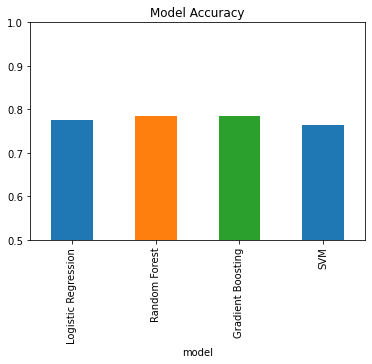

In [13]:
pred_score.plot(kind='bar',x='model',y='accuracy',title='Model Accuracy',legend=False,
        color=['#1F77B4', '#FF7F0E', '#2CA02C'])
plt.ylim(0.5,1);

## 5. Preparing for Submission

In [14]:
submission_preds = svc.predict(test)

In [15]:
df = pd.DataFrame({"PassengerId": test_ids.values,
                   "Transported": submission_preds
                  })

In [16]:
df.to_csv("submission.csv", index=False)

In [18]:
!kaggle competitions submit -c spaceship-titanic -f ./submission.csv -m "Submission with SVC"

100%|██████████████████████████████████████| 56.0k/56.0k [00:00<00:00, 87.2kB/s]
400 - Bad Request
